In [41]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import PPO


## Load Data

In [6]:
# Download data
spydata = yf.download('SPY', start='2018-01-01', end='2025-01-01', interval='1d', auto_adjust=False)
tltdata = yf.download('TLT', start='2018-01-01', end='2025-01-01', interval='1d', auto_adjust=False)
glddata = yf.download('GLD', start='2018-01-01', end='2025-01-01', interval='1d', auto_adjust=False)

datalist = [spydata, tltdata, glddata]
filenames = ['SPY_data.csv', 'TLT_data.csv', 'GLD_data.csv']

for data, filename in zip(datalist, filenames):
    data.to_csv(filename)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
# Load data
spydata = pd.read_csv('SPY_data.csv') # S&P 500
tltdata = pd.read_csv('TLT_data.csv') # Bond ETF
glddata = pd.read_csv('GLD_data.csv') # Gold ETF

In [8]:
spydata

,Price,Adj Close,Close,High,Low,Open,Volume
0,Ticker,SPY,SPY,SPY,SPY,SPY,SPY
1,Date,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-02,238.56875610351562,268.7699890136719,268.80999755859375,267.3999938964844,267.8399963378906,86655700
3,2018-01-03,240.07774353027344,270.4700012207031,270.6400146484375,268.9599914550781,268.9599914550781,90070400
4,2018-01-04,241.08956909179688,271.6099853515625,272.1600036621094,270.5400085449219,271.20001220703125,80636400
...,...,...,...,...,...,...,...
1758,2024-12-24,597.7295532226562,601.2999877929688,601.3400268554688,595.469970703125,596.0599975585938,33160100
1759,2024-12-26,597.7693481445312,601.3400268554688,602.47998046875,598.0800170898438,599.5,41219100
1760,2024-12-27,591.4768676757812,595.010009765625,597.780029296875,590.760009765625,597.5399780273438,64969300
1761,2024-12-30,584.7271728515625,588.219970703125,591.739990234375,584.4099731445312,587.8900146484375,56578800


In [9]:
tltdata

,Price,Adj Close,Close,High,Low,Open,Volume
0,Ticker,TLT,TLT,TLT,TLT,TLT,TLT
1,Date,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-02,102.43242645263672,125.48999786376953,126.51000213623047,125.06999969482422,126.48999786376953,16238200
3,2018-01-03,102.92220306396484,126.08999633789062,126.19999694824219,125.48999786376953,126.0,8605100
4,2018-01-04,102.9058609008789,126.06999969482422,126.16000366210938,125.37000274658203,125.6500015258789,9217900
...,...,...,...,...,...,...,...
1758,2024-12-24,85.68170928955078,87.87000274658203,87.88999938964844,86.9800033569336,87.04000091552734,22377600
1759,2024-12-26,85.63294219970703,87.81999969482422,87.95999908447266,87.19999694824219,87.20999908447266,19981800
1760,2024-12-27,84.9308853149414,87.0999984741211,87.77999877929688,87.05999755859375,87.4800033569336,27262300
1761,2024-12-30,85.61344909667969,87.80000305175781,88.04000091552734,87.66999816894531,87.83000183105469,48519600


In [10]:
glddata

,Price,Adj Close,Close,High,Low,Open,Volume
0,Ticker,GLD,GLD,GLD,GLD,GLD,GLD
1,Date,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-02,125.1500015258789,125.1500015258789,125.18000030517578,124.38999938964844,124.66000366210938,11762500
3,2018-01-03,124.81999969482422,124.81999969482422,125.08999633789062,124.0999984741211,125.05000305175781,7904300
4,2018-01-04,125.45999908447266,125.45999908447266,125.8499984741211,124.73999786376953,124.88999938964844,7329700
...,...,...,...,...,...,...,...
1758,2024-12-24,241.44000244140625,241.44000244140625,241.66000366210938,240.82000732421875,241.49000549316406,2421000
1759,2024-12-26,243.07000732421875,243.07000732421875,243.55999755859375,242.1999969482422,242.38999938964844,4645100
1760,2024-12-27,241.39999389648438,241.39999389648438,241.9499969482422,241.0500030517578,241.1999969482422,4728100
1761,2024-12-30,240.6300048828125,240.6300048828125,241.0800018310547,239.5800018310547,241.0800018310547,3522500


## Clean Data 

In [11]:
spydata_clean = spydata.iloc[2:].reset_index(drop=True)
spydata_clean['Date'] = pd.to_datetime(spydata_clean['Price'])
spydata_clean = spydata_clean.set_index('Date')
spydata_clean = spydata_clean[['Adj Close']]
spydata_clean = spydata_clean.rename(columns={'Adj Close': 'SPY'})

In [12]:
spydata_clean

,SPY
Date,
2018-01-02,238.56875610351562
2018-01-03,240.07774353027344
2018-01-04,241.08956909179688
2018-01-05,242.6962127685547
2018-01-08,243.1400909423828
...,...
2024-12-24,597.7295532226562
2024-12-26,597.7693481445312
2024-12-27,591.4768676757812


In [13]:
tltdata_clean = tltdata.iloc[2:].reset_index(drop=True)  
tltdata_clean['Date'] = pd.to_datetime(tltdata_clean['Price'])  
tltdata_clean = tltdata_clean.set_index('Date')  
tltdata_clean = tltdata_clean[['Adj Close']]  
tltdata_clean = tltdata_clean.rename(columns={'Adj Close': 'TLT'})  

In [14]:
glddata_clean = glddata.iloc[2:].reset_index(drop=True)
glddata_clean['Date'] = pd.to_datetime(glddata_clean['Price'])
glddata_clean = glddata_clean.set_index('Date')
glddata_clean = glddata_clean[['Adj Close']]
glddata_clean = glddata_clean.rename(columns={'Adj Close': 'GLD'})

## Return Calculation

In [15]:
prices = pd.concat([spydata_clean, tltdata_clean, glddata_clean], axis=1).dropna()

In [16]:
prices = prices.apply(pd.to_numeric)

In [17]:
prices

,SPY,TLT,GLD
Date,,,
2018-01-02,238.568756,102.432426,125.150002
2018-01-03,240.077744,102.922203,124.820000
2018-01-04,241.089569,102.905861,125.459999
2018-01-05,242.696213,102.611984,125.330002
2018-01-08,243.140091,102.546715,125.309998
...,...,...,...
2024-12-24,597.729553,85.681709,241.440002
2024-12-26,597.769348,85.632942,243.070007
2024-12-27,591.476868,84.930885,241.399994


In [18]:
returns = prices.pct_change()

In [19]:
returns

,SPY,TLT,GLD
Date,,,
2018-01-02,NaN,NaN,NaN
2018-01-03,0.006325,0.004781,-0.002637
2018-01-04,0.004215,-0.000159,0.005127
2018-01-05,0.006664,-0.002856,-0.001036
2018-01-08,0.001829,-0.000636,-0.000160
...,...,...,...
2024-12-24,0.011115,0.004229,0.001992
2024-12-26,0.000067,-0.000569,0.006751
2024-12-27,-0.010527,-0.008198,-0.006871


In [20]:
# Calculate expected returns (mean daily return)
expected_returns = returns.mean()

# Calculate covariance matrix (risk relationship between assets)
cov_matrix = returns.cov()

print("Expected Returns:")
print(expected_returns)
print("\nCovariance Matrix:")
print(cov_matrix)

Expected Returns:
SPY    0.000583
TLT   -0.000053
GLD    0.000416
dtype: float64

Covariance Matrix:
          SPY       TLT       GLD
SPY  0.000150 -0.000022  0.000012
TLT -0.000022  0.000104  0.000027
GLD  0.000012  0.000027  0.000081


In [21]:
len(expected_returns)

3

## MarkOwitz Model

In [22]:
window_size = 60           
rebalance_every = 20    

In [23]:
weights_over_time = []
dates = []

def portfolio_variance(weights, cov_matrix_window):
    return weights.T @ cov_matrix_window @ weights

for i in range(0, len(returns) - window_size, rebalance_every):
    window_returns = returns.iloc[i:i + window_size] * 100

    expected_returns_window = window_returns.mean()
    cov_matrix_window = window_returns.cov()

    print(f"Covariance matrix at window {i}:")
    print(cov_matrix_window)

    # Check variance for different initial guesses
    num_assets = len(expected_returns_window)
    init_guess = np.array([0.8,0.1,0.1])

    print("Variance at init_guess:", portfolio_variance(init_guess, cov_matrix_window))

    alt_guess = np.array([0.6] + [(0.4 / (num_assets - 1))]*(num_assets - 1))
    print("Variance at alternate guess:", portfolio_variance(alt_guess, cov_matrix_window))

    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((0, 1) for _ in range(num_assets))

    opt_result = minimize(portfolio_variance,
                          init_guess,
                          args=(cov_matrix_window,),
                          method='SLSQP',
                          bounds=bounds,
                          constraints=constraints)

    print("Optimization success:", opt_result.success)
    print("Optimization message:", opt_result.message)
    print("Optimized weights:", opt_result.x)
    print("Optimized variance:", portfolio_variance(opt_result.x, cov_matrix_window))
    
    weights_over_time.append(opt_result.x)
    dates.append(returns.index[i + window_size])

Covariance matrix at window 0:
          SPY       TLT       GLD
SPY  1.607726 -0.157417  0.130792
TLT -0.157417  0.390933  0.018513
GLD  0.130792  0.018513  0.461745
Variance at init_guess: 1.033581458264156
Variance at alternate guess: 0.6079794741056295
Optimization success: True
Optimization message: Optimization terminated successfully
Optimized weights: [0.13874991 0.5170247  0.34422539]
Optimized variance: 0.18666404615715768
Covariance matrix at window 20:
          SPY       TLT       GLD
SPY  1.870153 -0.212862  0.002516
TLT -0.212862  0.396787  0.067696
GLD  0.002516  0.067696  0.474282
Variance at init_guess: 1.173306901539268
Variance at alternate guess: 0.6630303339305963
Optimization success: True
Optimization message: Optimization terminated successfully
Optimized weights: [0.15988799 0.51111228 0.32899972]
Optimized variance: 0.19104170136738183
Covariance matrix at window 40:
          SPY       TLT       GLD
SPY  1.041411 -0.173329 -0.047682
TLT -0.173329  0.314841  

<Axes: title={'center': 'Dynamic Markowitz Portfolio Weights Over Time'}>

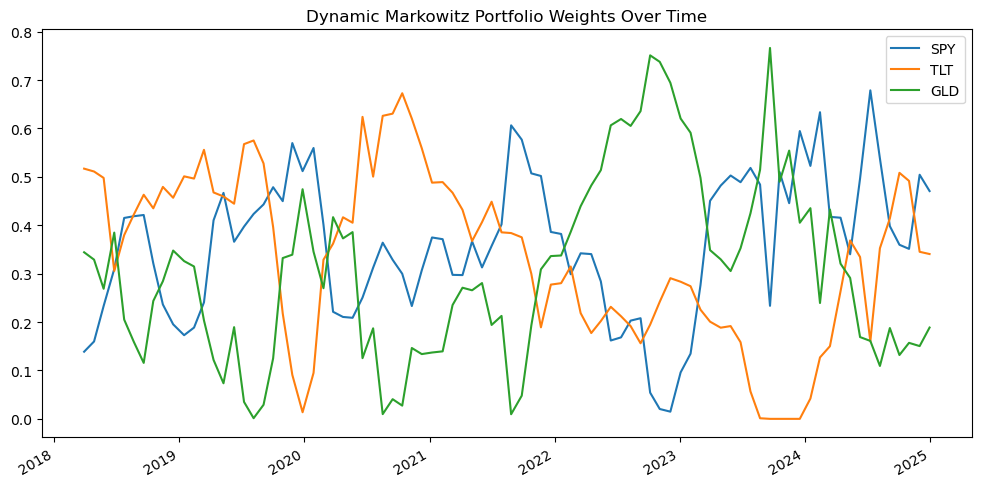

In [24]:
weights_df = pd.DataFrame(weights_over_time, columns=returns.columns, index=dates)

# Optional: Plot weight changes over time
weights_df.plot(figsize=(12, 6), title="Dynamic Markowitz Portfolio Weights Over Time")

In [25]:
weights_df

,SPY,TLT,GLD
2018-03-29,0.138750,0.517025,0.344225
2018-04-27,0.159888,0.511112,0.329000
2018-05-25,0.233248,0.497913,0.268839
2018-06-25,0.309631,0.305500,0.384869
2018-07-24,0.415167,0.379676,0.205157
...,...,...,...
2024-09-06,0.398219,0.414140,0.187641
2024-10-04,0.359726,0.508381,0.131893
2024-11-01,0.351244,0.491692,0.157065
2024-12-02,0.504416,0.345201,0.150383


<Axes: title={'center': 'Cumulative Returns of Dynamic Markowitz Portfolio'}>

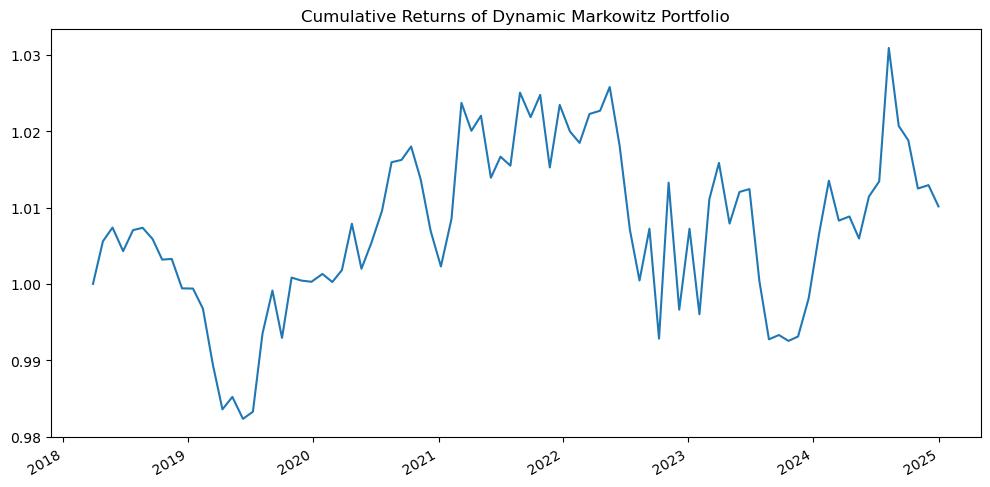

In [26]:
# Create portfolio returns from weights
portfolio_returns = (weights_df.shift(1) * returns.loc[weights_df.index]).sum(axis=1)

# Cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod()

# Plot cumulative returns
cumulative_returns.plot(figsize=(12,6), title="Cumulative Returns of Dynamic Markowitz Portfolio")

In [27]:
annualized_return = portfolio_returns.mean() * 252
annualized_volatility = portfolio_returns.std() * np.sqrt(252)
sharpe_ratio = annualized_return / annualized_volatility

print("Annualized Return:", annualized_return)
print("Annualized Volatility:", annualized_volatility)
print("Sharpe Ratio:", sharpe_ratio)

Annualized Return: 0.035271444060414985
Annualized Volatility: 0.10733788590683159
Sharpe Ratio: 0.3286020007048612


## Markowitz with LSTM Model

In [28]:
def prepare_multivariate_data(data, window_size=60):
    scalers = {}
    scaled_data = pd.DataFrame(index=data.index)

    for col in data.columns:
        scaler = MinMaxScaler()
        scaled_data[col] = scaler.fit_transform(data[[col]])
        scalers[col] = scaler

    X, y = [], []
    for i in range(window_size, len(scaled_data)):
        X.append(scaled_data.iloc[i-window_size:i].values)  
        y.append(scaled_data.iloc[i].values)                
    
    return np.array(X), np.array(y), scalers, scaled_data

# Train LSTM model
def build_multivariate_lstm(n_assets, window_size=60):
    model = Sequential([
        LSTM(64, return_sequences=False, input_shape=(window_size, n_assets)),
        Dense(n_assets)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def predict_on_existing_data(model, X, scaled_data, scalers, original_data, window_size=60):
    predicted_scaled = []

    for i in range(window_size, len(scaled_data)):
        input_seq = X[i - window_size:i - window_size + 1]  
        pred = model.predict(input_seq, verbose=0)[0]       
        predicted_scaled.append(pred)

    pred_df = pd.DataFrame(predicted_scaled, columns=scaled_data.columns)
    
    for col in pred_df.columns:
        pred_df[col] = scalers[col].inverse_transform(pred_df[[col]])

    pred_df.index = original_data.index[window_size:]
    pred_df = pd.concat([original_data.iloc[0:window_size], pred_df], axis=0).dropna()
    return pred_df


In [29]:
window_size = 60
X, y, scalers, scaled_data = prepare_multivariate_data(prices, window_size)
model = build_multivariate_lstm(n_assets=X.shape[2], window_size=window_size)
model.fit(X, y, epochs=20, batch_size=32)

pred_df = predict_on_existing_data(model, X, scaled_data, scalers, prices, window_size)

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0779
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 9.0450e-04
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.2237e-04
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.0519e-04
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.4332e-04
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.0154e-04
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.7833e-04
Epoch 9/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.1018e-04
Epoch 10/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.4523e-04
Epoch 11/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.6039e-04
Epoch 12/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2677e-04
Epoch 13/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.3760e-04
Epoch 14/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.1411e-04
Epoch 15/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/s

In [30]:
pred_df

,SPY,TLT,GLD
Date,,,
2018-01-02,238.568756,102.432426,125.150002
2018-01-03,240.077744,102.922203,124.820000
2018-01-04,241.089569,102.905861,125.459999
2018-01-05,242.696213,102.611984,125.330002
2018-01-08,243.140091,102.546715,125.309998
...,...,...,...
2024-12-24,590.780457,88.105644,241.197327
2024-12-26,591.510925,87.884674,241.015244
2024-12-27,592.300415,87.686539,241.046204


In [31]:
prices

,SPY,TLT,GLD
Date,,,
2018-01-02,238.568756,102.432426,125.150002
2018-01-03,240.077744,102.922203,124.820000
2018-01-04,241.089569,102.905861,125.459999
2018-01-05,242.696213,102.611984,125.330002
2018-01-08,243.140091,102.546715,125.309998
...,...,...,...
2024-12-24,597.729553,85.681709,241.440002
2024-12-26,597.769348,85.632942,243.070007
2024-12-27,591.476868,84.930885,241.399994


In [32]:
returns_pred = pred_df.pct_change()

In [33]:
returns

,SPY,TLT,GLD
Date,,,
2018-01-02,NaN,NaN,NaN
2018-01-03,0.006325,0.004781,-0.002637
2018-01-04,0.004215,-0.000159,0.005127
2018-01-05,0.006664,-0.002856,-0.001036
2018-01-08,0.001829,-0.000636,-0.000160
...,...,...,...
2024-12-24,0.011115,0.004229,0.001992
2024-12-26,0.000067,-0.000569,0.006751
2024-12-27,-0.010527,-0.008198,-0.006871


In [34]:
returns_pred

,SPY,TLT,GLD
Date,,,
2018-01-02,NaN,NaN,NaN
2018-01-03,0.006325,0.004781,-0.002637
2018-01-04,0.004215,-0.000159,0.005127
2018-01-05,0.006664,-0.002856,-0.001036
2018-01-08,0.001829,-0.000636,-0.000160
...,...,...,...
2024-12-24,-0.001082,-0.004343,-0.001973
2024-12-26,0.001236,-0.002508,-0.000755
2024-12-27,0.001335,-0.002254,0.000128


In [35]:
weights_over_time_pred = []
dates_pred = []

def portfolio_variance(weights, cov_matrix_window):
    return weights.T @ cov_matrix_window @ weights

for i in range(0, len(returns_pred) - window_size, rebalance_every):
    window_returns_pred = returns_pred.iloc[i:i + window_size] * 100

    expected_returns_window_pred = window_returns_pred.mean()
    cov_matrix_window_pred = window_returns_pred.cov()

    print(f"Covariance matrix at window {i}:")
    print(cov_matrix_window_pred)

    # Check variance for different initial guesses
    num_assets = len(expected_returns_window_pred)
    init_guess = np.array([0.8,0.1,0.1])

    print("Variance at init_guess:", portfolio_variance(init_guess, cov_matrix_window_pred))

    alt_guess = np.array([0.6] + [(0.4 / (num_assets - 1))]*(num_assets - 1))
    print("Variance at alternate guess:", portfolio_variance(alt_guess, cov_matrix_window_pred))

    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((0, 1) for _ in range(num_assets))

    opt_result_pred = minimize(portfolio_variance,
                          init_guess,
                          args=(cov_matrix_window_pred,),
                          method='SLSQP',
                          bounds=bounds,
                          constraints=constraints)

    print("Optimization success:", opt_result_pred.success)
    print("Optimization message:", opt_result_pred.message)
    print("Optimized weights:", opt_result_pred.x)
    print("Optimized variance:", portfolio_variance(opt_result_pred.x, cov_matrix_window_pred))
    
    weights_over_time_pred.append(opt_result_pred.x)
    dates_pred.append(returns.index[i + window_size])

Covariance matrix at window 0:
          SPY       TLT       GLD
SPY  1.607726 -0.157417  0.130792
TLT -0.157417  0.390933  0.018513
GLD  0.130792  0.018513  0.461745
Variance at init_guess: 1.033581458264156
Variance at alternate guess: 0.6079794741056295
Optimization success: True
Optimization message: Optimization terminated successfully
Optimized weights: [0.13874991 0.5170247  0.34422539]
Optimized variance: 0.18666404615715768
Covariance matrix at window 20:
          SPY       TLT       GLD
SPY  1.653599 -0.185270  0.103004
TLT -0.185270  0.303873  0.013384
GLD  0.103004  0.013384  0.359084
Variance at init_guess: 1.0520380218548866
Variance at alternate guess: 0.6031407693185005
Optimization success: True
Optimization message: Optimization terminated successfully
Optimized weights: [0.12493746 0.53206291 0.34299963]
Optimized variance: 0.14316288118020254
Covariance matrix at window 40:
          SPY       TLT       GLD
SPY  0.723532 -0.163021  0.017303
TLT -0.163021  0.125583 

<Axes: title={'center': 'Dynamic Markowitz Portfolio Weights Over Time'}>

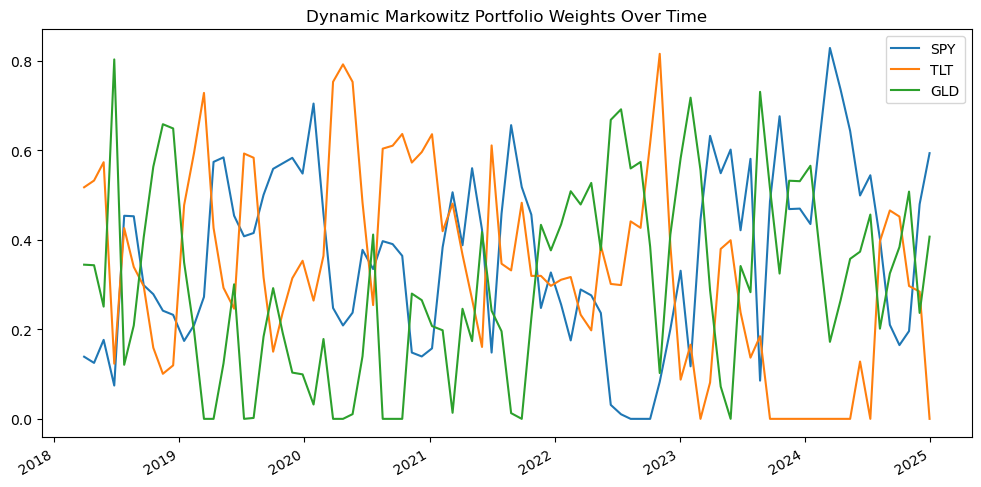

In [36]:
weights_pred_df = pd.DataFrame(weights_over_time_pred, columns=returns_pred.columns, index=dates_pred)
weights_pred_df.plot(figsize=(12, 6), title="Dynamic Markowitz Portfolio Weights Over Time")

<Axes: title={'center': 'Cumulative Returns of Dynamic Markowitz Portfolio'}>

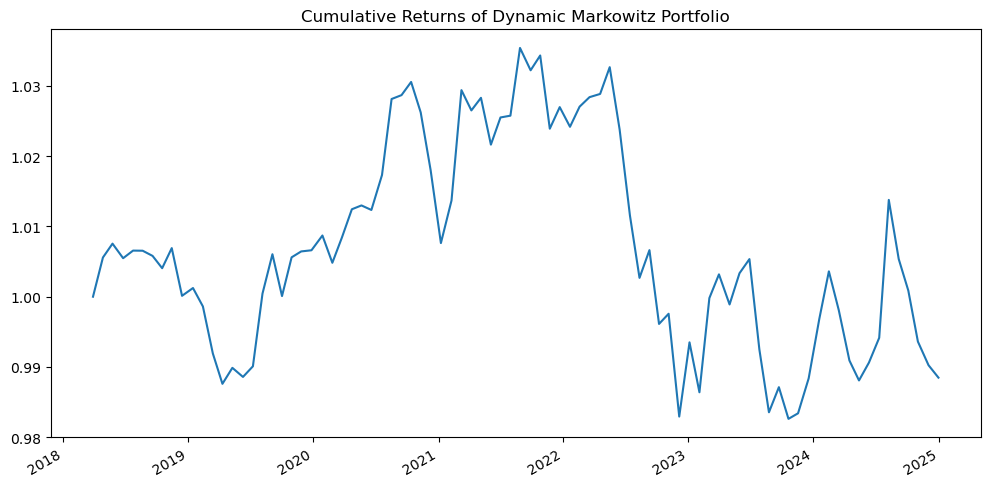

In [37]:
# Create portfolio returns from weights
portfolio_returns_pred = (weights_pred_df.shift(1) * returns.loc[weights_pred_df.index]).sum(axis=1)

# Cumulative returns
cumulative_returns_pred = (1 + portfolio_returns_pred).cumprod()

# Plot cumulative returns
cumulative_returns_pred.plot(figsize=(12,6), title="Cumulative Returns of Dynamic Markowitz Portfolio")

In [38]:
annualized_return_pred = portfolio_returns_pred.mean() * 252
annualized_volatility_pred = portfolio_returns_pred.std() * np.sqrt(252)
sharpe_ratio_pred = annualized_return_pred / annualized_volatility_pred

print("Annualized Return:", annualized_return_pred)
print("Annualized Volatility:", annualized_volatility_pred)
print("Sharpe Ratio:", sharpe_ratio_pred)

Annualized Return: -0.028861376835553506
Annualized Volatility: 0.10130600989929744
Sharpe Ratio: -0.28489303708874686


## Reinforcement Learning

In [39]:
class PortfolioEnv(gym.Env):
    def __init__(self, price_df, window_size=60, initial_balance=1_000_000):
        super(PortfolioEnv, self).__init__()
        self.price_df = price_df
        self.window_size = window_size
        self.initial_balance = initial_balance
        self.n_assets = price_df.shape[1]

        self.action_space = spaces.Box(
            low=0, high=1, shape=(self.n_assets,), dtype=np.float32
        )
        
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(window_size, self.n_assets), dtype=np.float32
        )

    def reset(self):
        self.current_step = self.window_size
        self.balance = self.initial_balance
        self.weights = np.ones(self.n_assets) / self.n_assets
        return self._get_observation()

    def _get_observation(self):
        return self.price_df.iloc[self.current_step - self.window_size:self.current_step].pct_change().dropna().values

    def step(self, action):
        action = np.clip(action, 0, 1)
        action /= np.sum(action)

        prev_prices = self.price_df.iloc[self.current_step - 1].values
        curr_prices = self.price_df.iloc[self.current_step].values
        returns = (curr_prices - prev_prices) / prev_prices
        portfolio_return = np.dot(returns, action)

        reward = portfolio_return
        self.current_step += 1
        done = self.current_step >= len(self.price_df) - 1

        return self._get_observation(), reward, done, {}

    def render(self, mode='human'):
        pass

In [43]:
env = DummyVecEnv([lambda: PortfolioEnv(prices)])

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100_000)

/opt/anaconda3/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


NotImplementedError: Cannot convert space of type Box(-inf, inf, (60, 3), float32). Please upgrade your code to gymnasium.

In [ ]:
obs = env.reset()
done = False
portfolio_values = []

while not done:
    action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)
    portfolio_values.append(reward)  # or track balance if you modify your env to include it